In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
import os
import shutil
import random

def split_dataset(original_dataset_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    classes = os.listdir(original_dataset_dir)  # List all classes

    for class_name in classes:
        class_path = os.path.join(original_dataset_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)  # Shuffle to ensure randomness

        train_size = int(split_ratio[0] * len(images))
        val_size = int(split_ratio[1] * len(images))

        # Split into train, validation, and test sets
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]

        # Create destination folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Move files to respective folders
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

# Usage
split_dataset(
    original_dataset_dir='dataset/villagedataset',  # Source folder
    train_dir='dataset/train',
    val_dir='dataset/validation',
    test_dir='dataset/test'
)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset/villagedataset'

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation/test

# Load images from dataset directories
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(150, 150), batch_size=32, class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(150, 150), batch_size=32, class_mode='categorical'
)

Found 37997 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.


In [5]:
# Define the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),  # Flatten the feature maps to feed into Dense layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

# Compile the Model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model Summary
model.summary()


c:\Users\goyal\miniconda3\envs\DL\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,053,158 (72.68 MB)

 Trainable params: 19,053,158 (72.68 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

c:\Users\goyal\miniconda3\envs\DL\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.3765 - loss: 2.3372

c:\Users\goyal\miniconda3\envs\DL\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1187/1187 ━━━━━━━━━━━━━━━━━━━━ 754s 632ms/step - accuracy: 0.3766 - loss: 2.3368 - val_accuracy: 0.7237 - val_loss: 0.8753
Epoch 2/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.7188 - loss: 0.7917 - val_accuracy: 1.0000 - val_loss: 0.8816
Epoch 3/10


c:\Users\goyal\miniconda3\envs\DL\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1187/1187 ━━━━━━━━━━━━━━━━━━━━ 694s 584ms/step - accuracy: 0.6829 - loss: 1.0407 - val_accuracy: 0.8081 - val_loss: 0.6106
Epoch 4/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.8125 - loss: 0.8372 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 616s 518ms/step - accuracy: 0.7581 - loss: 0.7707 - val_accuracy: 0.8207 - val_loss: 0.5777
Epoch 6/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.8125 - loss: 0.7133 - val_accuracy: 1.0000 - val_loss: 0.1557
Epoch 7/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 581s 489ms/step - accuracy: 0.8065 - loss: 0.6192 - val_accuracy: 0.8567 - val_loss: 0.4360
Epoch 8/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.9062 - loss: 0.3012 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 574s 483ms/step - accuracy: 0.8289 - loss: 0.5421 - val_accuracy: 0.8951 - val_loss: 0.3131
Epoch 10/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.9375 - l

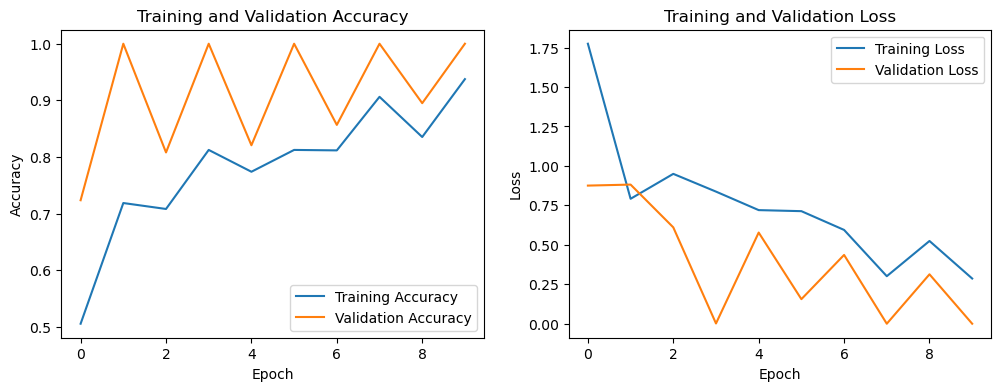

In [9]:
# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [10]:
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Found 8179 images belonging to 38 classes.


c:\Users\goyal\miniconda3\envs\DL\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.9050 - loss: 0.2768
Test Accuracy: 90.06%


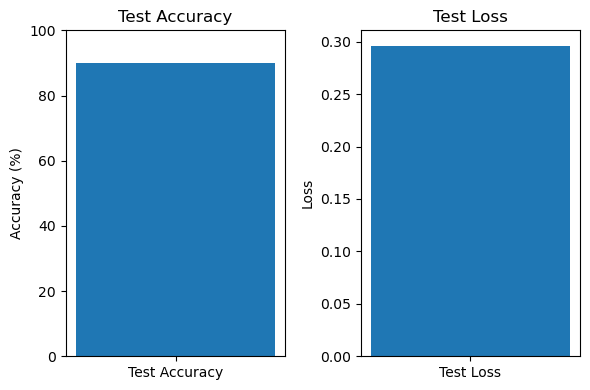

In [11]:
# Plot Test Accuracy and Loss
plt.figure(figsize=(6, 4))

# Test Accuracy
plt.subplot(1, 2, 1)
plt.bar(['Test Accuracy'], [test_accuracy * 100])
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

# Test Loss
plt.subplot(1, 2, 2)
plt.bar(['Test Loss'], [test_loss])
plt.ylabel('Loss')
plt.title('Test Loss')

plt.tight_layout()
plt.show()

256/256 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step


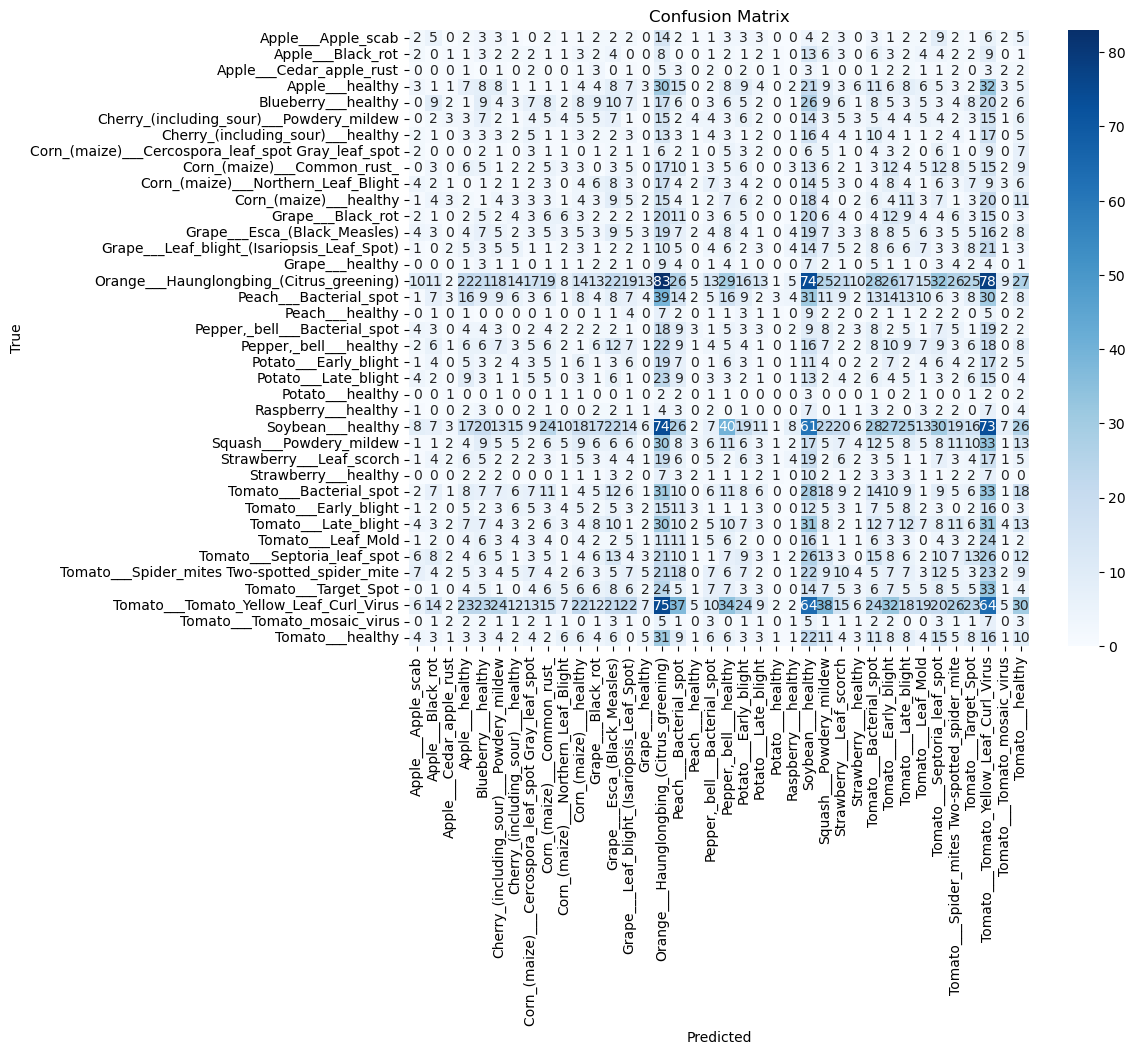

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.02      0.02      0.02        95
                                 Apple___Black_rot       0.00      0.00      0.00        94
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        42
                                   Apple___healthy       0.04      0.03      0.03       248
                               Blueberry___healthy       0.04      0.04      0.04       226
          Cherry_(including_sour)___Powdery_mildew       0.01      0.01      0.01       159
                 Cherry_(including_sour)___healthy       0.02      0.02      0.02       129
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.02      0.04      0.03        78
                       Corn_(maize)___Common_rust_       0.03      0.03      0.03       180
               Corn_(maize)___Northern_Leaf_Blight       0.00      0.00      0.

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Get the true labels and predictions
true_labels = test_generator.classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))